In [7]:
from matplotlib import pylab as plt
from sklearn.metrics import mean_squared_error
from itertools import compress
import xml.etree.ElementTree as ET
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

from tqdm.notebook import tqdm


from time import time
import rascal
import json
import math

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
from ase.geometry import wrap_positions
import numpy as np

from rascal.representations import SphericalInvariants
from rascal.models import Kernel, train_gap_model
from rascal.models.asemd import ASEMLCalculator
from rascal.utils import from_dict, to_dict, CURFilter, dump_obj, load_obj, get_score, print_score, FPSFilter

In [8]:
'''
This file is used to generate the parity plots of the energies before
subtracting the R6 potential and after subtracting the R6 potential.
'''

'\nThis file is used to generate the parity plots of the energies before\nsubtracting the R6 potential and after subtracting the R6 potential.\n'

In [9]:
def extract_ref(frames,energy_key=True,forces_key=True,number_key=True):
    e,f,n = [], [], []
    for frame in frames:
        if energy_key:
            e.append(frame.info['energy'])
        if forces_key:
            f.append(frame.get_array('forces'))
        if number_key:
            n.append(len(frame))        
    e = np.array(e)
    n = np.array(n)
    try:
        f = np.concatenate(f)
    except:
        pass
    return e,f,n

In [10]:
N = 4798
frames_train_o = read('P_GAP_20_fitting_data.xyz', index=':{}'.format(N))
frames_train_n = read('training_data_no_baseline.xyz', index=':{}'.format(N))

N2 = 1601
frames_test_o = read('P_test_set.xyz', index=':{}'.format(N2))
frames_test_n = read('test_data_no_baseline.xyz', index=':{}'.format(N2))

y_train_o, f_train_o, n_train_o = extract_ref(frames_train_o,True,True,True)
y_train_o_atom = y_train_o/n_train_o
y_train_n, f_train_n, n_train_n = extract_ref(frames_train_n,True,True,True)
y_train_n_atom = y_train_n/n_train_n
y_test_o, f_test_o, n_test_o = extract_ref(frames_test_o,True,True,True)
y_test_o_atom = y_test_o/n_test_o
y_test_n, f_test_n, n_test_n = extract_ref(frames_test_n,True,True,True)
y_test_n_atom = y_test_n/n_test_n

In [11]:
### Sorting training set
print('Sorting training set:')
dataset={'P2/P4':[]}
for i in range(N):
    try:
        name=frames_train_n[i].info['config_type']
        if name in dataset:
            dataset[name].append(i)
        else:
            dataset[name]=[i]
    except:
        dataset['P2/P4'].append(i)
for key in dataset.keys():
    print('Number of frames in '+str(key)+" : "+str(len(dataset[key])))
    
### Sorting test set
print('Sorting test set:')
dataset2={'P2/P4':[]}
for i in range(N2):
    try:
        name=frames_test_n[i].info['config_type']
        if name in dataset2:
            dataset2[name].append(i)
        else:
            dataset2[name]=[i]
    except:
        dataset2['P2/P4'].append(i)
for key in dataset2.keys():
    print('Number of frames in '+str(key)+" : "+str(len(dataset2[key])))


print(' ')

### check if we have considered all frames

idxs=list(dataset.values())
n_keys=len(dataset.keys())
checklist=[]
status=True

for i in range(n_keys):
    checklist+=idxs[i]
    
for i in range(N):
    if i in checklist:
        pass
    elif i not in checklist:
        print('Warning: missed frame: '+str(i))
        status=False
if status:
    print('All frames in training set are checked!')


idxs2=list(dataset2.values())
n_keys2=len(dataset2.keys())
checklist2=[]
status2=True

for i in range(n_keys2):
    checklist2+=idxs2[i]
    
for i in range(N2):
    if i in checklist2:
        pass
    elif i not in checklist2:
        print('Warning: missed frame: '+str(i))
        status2=False
if status2:
    print('All frames in test set are checked!')

Sorting training set:
Number of frames in P2/P4 : 35
Number of frames in liq_12_03_01_liqP4 : 88
Number of frames in liq_12_03_02_network : 164
Number of frames in phosphorene : 87
Number of frames in phosphorus_ribbons : 40
Number of frames in rss_3c : 400
Number of frames in cryst_dist : 959
Number of frames in 2D : 1234
Number of frames in rss_200 : 596
Number of frames in rss_005 : 995
Number of frames in rss_rnd : 199
Number of frames in isolated_atom : 1
Sorting test set:
Number of frames in P2/P4 : 0
Number of frames in 2D : 309
Number of frames in cryst_dist : 241
Number of frames in cryst_dist_hp : 337
Number of frames in liq_12_03_01_liqP4 : 22
Number of frames in liq_12_03_02_network : 41
Number of frames in liq_P4 : 100
Number of frames in rss_005 : 247
Number of frames in rss_200 : 154
Number of frames in rss_3c : 100
Number of frames in rss_rnd : 50
 
All frames in training set are checked!
All frames in test set are checked!


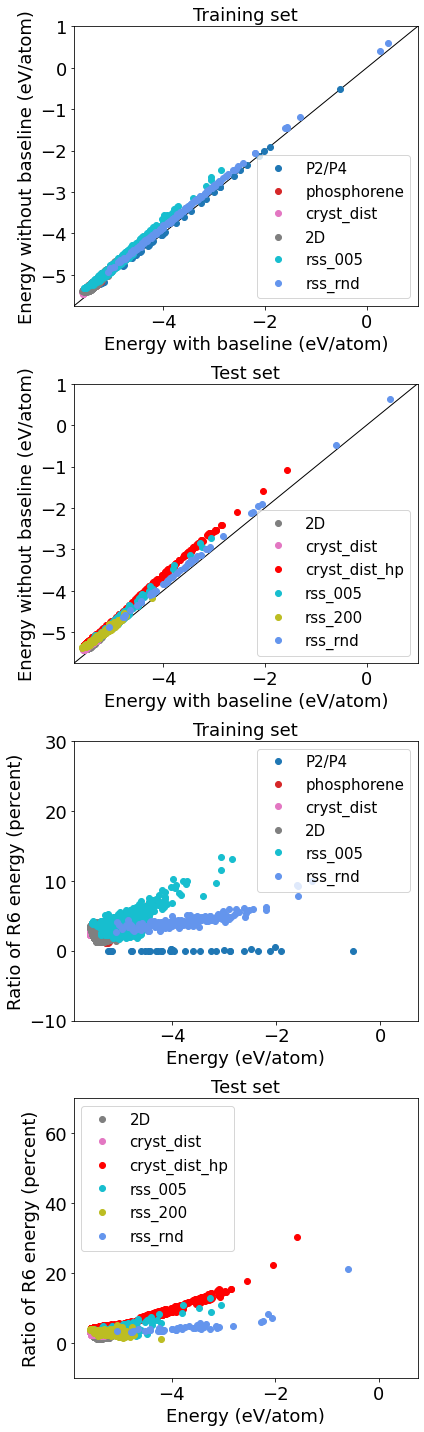

In [12]:
fig, ax = plt.subplots(nrows=4,figsize=(6,20))
ax[0].set_xlim(-5.75,1)
ax[0].set_ylim(-5.75,1)
ax[1].set_xlim(-5.75,1)
ax[1].set_ylim(-5.75,1)
ax[2].set_ylim(-10,30)
ax[3].set_ylim(-10,70)
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes,color='k',linewidth=1)
ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes,color='k',linewidth=1)

ax[0].set_xlabel('Energy with baseline (eV/atom)',fontsize=18)
ax[0].set_ylabel('Energy without baseline (eV/atom)',fontsize=18)
ax[0].set_title('Training set',fontsize=18)

ax[1].set_xlabel('Energy with baseline (eV/atom)',fontsize=18)
ax[1].set_ylabel('Energy without baseline (eV/atom)',fontsize=18)
ax[1].set_title('Test set',fontsize=18)

ax[2].set_xlabel('Energy (eV/atom)',fontsize=18)
ax[2].set_ylabel('Ratio of R6 energy (percent)',fontsize=18)
ax[2].set_title('Training set',fontsize=18)

ax[3].set_xlabel('Energy (eV/atom)',fontsize=18)
ax[3].set_ylabel('Ratio of R6 energy (percent)',fontsize=18)
ax[3].set_title('Test set',fontsize=18)

color_dic={
    'P2/P4':'tab:blue',
    'liq_12_03_01_liqP4':'tab:orange',
    'liq_P4':'tab:orange',
    'liq_12_03_02_network':'tab:green',
    'phosphorene':'tab:red',
    'phosphorus_ribbons':'tab:purple',
    'rss_3c':'tab:brown',
    'cryst_dist':'tab:pink',
    '2D':'tab:gray',
    'rss_200':'tab:olive',
    'rss_005':'tab:cyan',
    'rss_rnd':'cornflowerblue',
    'isolated_atom':'b',
    'cryst_dist_hp':'r'
}

selectedTr=['P2/P4','rss_005','rss_rnd','cryst_dist','phosphorene','2D']
selectedTe=['cryst_dist_hp','cryst_dist','rss_005','rss_200','rss_rnd','2D']

for key in dataset.keys():
    if key in selectedTr:
        y_train_o_temp=[]
        y_train_n_temp=[]
        ratio=[]
        for i in dataset[key]:
            y_train_o_temp.append(y_train_o_atom[i])
            y_train_n_temp.append(y_train_n_atom[i])
            ratio.append(-100*(y_train_n_atom[i]-y_train_o_atom[i])/y_train_o_atom[i])
        ax[0].plot(y_train_o_temp,y_train_n_temp,'o',label=key,markersize=6,color=color_dic[key])
        ax[2].plot(y_train_o_temp,ratio,'o',label=key,markersize=6,color=color_dic[key])
    else:
        continue
for key in dataset2.keys():
    if key in selectedTe:
        y_test_o_temp=[]
        y_test_n_temp=[]
        ratio=[]
        for i in dataset2[key]:
            y_test_o_temp.append(y_test_o_atom[i])
            y_test_n_temp.append(y_test_n_atom[i])
            ratio.append(-100*(y_test_n_atom[i]-y_test_o_atom[i])/y_test_o_atom[i])
        ax[1].plot(y_test_o_temp,y_test_n_temp,'o',label=key,markersize=6,color=color_dic[key])
        ax[3].plot(y_test_o_temp,ratio,'o',label=key,markersize=6,color=color_dic[key])
    else:
        continue

ax[0].legend(markerscale=1.,fontsize=15)
ax[1].legend(markerscale=1.,fontsize=15)
ax[2].legend(markerscale=1.,fontsize=15)
ax[3].legend(markerscale=1.,fontsize=15)
ax[0].tick_params(axis='both',labelsize=18)
ax[1].tick_params(axis='both',labelsize=18)
ax[2].tick_params(axis='both',labelsize=18)
ax[3].tick_params(axis='both',labelsize=18)

plt.tight_layout()

#ax[0].legend(markerscale=2.5,loc='center left',fontsize='large',bbox_to_anchor=(1, 0.5))
#ax[1].legend(markerscale=2.5,loc='center left',fontsize='large',bbox_to_anchor=(1, 0.5))
#ax[2].legend(markerscale=2.5,loc='center left',fontsize='large',bbox_to_anchor=(1, 0.5))
#ax[3].legend(markerscale=2.5,loc='center left',fontsize='large',bbox_to_anchor=(1, 0.5))